In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import dblquad
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime, timedelta
%matplotlib inline

In [2]:
lat_min, lat_max = 31.1, 31.4
lon_min, lon_max = 121.3, 121.8
lat_ctr = (int)((lat_max - lat_min) / 0.005)
lon_ctr = (int)((lon_max - lon_min) / 0.005)

def lat_quantize(lat):
    return (int)((lat - lat_min) / 0.005)
def lon_quantize(lon):
    return (int)((lon - lon_min) / 0.005)

In [3]:
rcar_dtype = {'car_id': str,
                  'date_time': str,
                  'lat': float,
                  'lon': float,
                  'power_mode': str,
                  'mileage': float,
                  'speed': float,
                  'fuel_consumption': float}
ecar_dtype = {'car_id': str,
                  'date_time': str,
                  'lat': float,
                  'lon': float,
                  'work_mode': str,
                  'mileage': float,
                  'speed': float,
                  'avg_fuel_consumption': float,
                  'system_mode': str}

In [4]:
data = pd.read_csv("./data/rcar/BOT_data_rcar_20170102_20170102_part0.csv", dtype=rcar_dtype)
data = data[(data['lat'] > 0.1) & (data['lon'] > 0.1)]
data["date_time"] = data["date_time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [11]:
data = pd.read_csv("./data/ecar/BOT_data_ecar_20170102_20170102_part0.csv", dtype=ecar_dtype)
data = data[(data['lat'] > 0.1) & (data['lon'] > 0.1)]
data["date_time"] = data["date_time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [4]:
def integrate_density(density):
    for col in range(1,density.shape[1]):
        density[0][col] += density[0][col-1];
    for row in range(1,density.shape[0]):
        density[row][0] += density[row-1][0]
        for col in range(1,density.shape[1]):
            density[row][col] += (density[row][col-1] 
                                + density[row-1][col] 
                                - density[row-1][col-1]);
                
    return density

In [22]:
def extract_hist(data):
    hist, xedges, yedges = np.histogram2d(data['lat'], data['lon'],
        bins = [range(lat_ctr),
                range(lon_ctr)],
        range=[[0, lat_ctr],
               [0, lon_ctr]])
    #hist = integrate_density(hist)
    #xpos, ypos = np.meshgrid(xedges[1:], yedges[1:])
    #X = np.stack((xpos.flatten(), ypos.flatten()), axis=1)
    #y = hist.flatten()
    #return X, y
    return hist

/home/jachinshen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jachinshen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


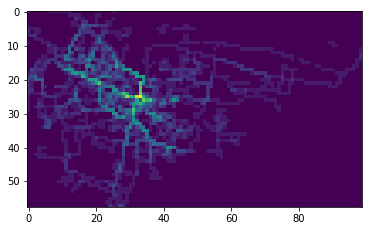

In [12]:
def get_density_hour(data, hour_begin, hour_end):
    data_hour = data[(hour_begin <= data['date_time']) & (data['date_time'] < hour_end)]
    data_hour['lat'] = data_hour['lat'].apply(lambda lat:
        (int)((lat-lat_min) / 0.005))
    data_hour['lon'] = data_hour['lon'].apply(lambda lon:
        (int)((lon-lon_min) / 0.005))
    data_hour = data_hour.drop_duplicates(['car_id', 'lat', 'lon'])
    hist  = extract_hist(data_hour)
    '''
    fig = plt.figure(figsize=(12, 8))
    ax = fig.gca(projection='3d')
    
    ax.plot_surface(xpos, ypos, hist, cmap=cm.coolwarm, 
                    linewidth=0, antialiased=False)
    ax.set_xlabel("lat")
    ax.set_ylabel("lon")
    #ax.set_zlim(0, 2000)
    fig.suptitle("{} to {}".format(hour_begin, hour_end))
    plt.show()
    '''
    return hist

hist = get_density_hour(data, datetime(2017, 1, 2, 13), datetime(2017, 1, 2, 14))
plt.imshow(hist)
plt.show()

In [36]:
def get_range_density(hist, range_xy):
    #center_lat = lat_quantize((range_xy[0][0] + range_xy[0][1]) / 2)
    #center_lon = lon_quantize((range_xy[1][0] + range_xy[1][1]) / 2)
    center_lat = lat_quantize(range_xy[0][0])
    center_lon = lon_quantize(range_xy[1][0])
    return (int)(hist[center_lat][center_lon])
print(get_range_density(hist, [[31.31, 31.315], [121.790, 121.795]]))

0


In [13]:
X_sub['car_number'] = X_sub.apply(
        lambda row: get_range_density(hist,
            [row['latitude_range'], row['longitude_range']]), axis=1)

In [17]:
def convert_str_range(string):
    string_split = string.split('~')
    return list(map(float, string_split))
def get_submission_range():
    X_sub = pd.read_csv("./A-test.csv")
    X_sub['latitude_range'] = X_sub['latitude_range'].apply(convert_str_range)
    X_sub['longitude_range'] = X_sub['longitude_range'].apply(convert_str_range)
    return X_sub
X_sub = get_submission_range()

In [16]:
def get_dataset():
    frames = []
    features_need = ['car_id', 'date_time', 'lat', 'lon']
    rcar_dtype = {'car_id': str,
                  'date_time': str,
                  'lat': float,
                  'lon': float,
                  'power_mode': str,
                  'mileage': float,
                  'speed': float,
                  'fuel_consumption': float}
    ecar_dtype = {'car_id': str,
                  'date_time': str,
                  'lat': float,
                  'lon': float,
                  'work_mode': str,
                  'mileage': float,
                  'speed': float,
                  'avg_fuel_consumption': float,
                  'system_mode': str}
    for part in range(3):
        filename = ("./data/rcar/BOT_data_rcar_20170306_20170306_part{}.csv"
                    .format(part))
        data_part = pd.read_csv(filename, dtype=rcar_dtype)[features_need]
        data_part = data_part[(data_part['lat'] > 0.1) & (data_part['lon'] > 0.1)]
        frames.append(data_part)
        
        filename = ("./data/ecar/BOT_data_ecar_20170306_20170306_part{}.csv"
                    .format(part))
        data_part = pd.read_csv(filename, dtype={'system_mode': str})[features_need]
        data_part = data_part[(data_part['lat'] > 0.1) & (data_part['lon'] > 0.1)]
        frames.append(data_part)
        
    data = pd.concat(frames)
    data["date_time"] = data["date_time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
    return data

In [23]:
def unit_1(hour):
    data = get_dataset()
    return data
data = unit_1(9)

In [28]:
data

,car_id,date_time,lat,lon
0,r34235,2017-03-06 00:03:53,31.018168,121.365860
1,r71264,2017-03-06 15:22:47,31.330719,121.496815
2,r71264,2017-03-06 15:22:52,31.330717,121.496911
3,r5038,2017-03-06 00:22:25,31.042855,121.449329
4,r5038,2017-03-06 00:22:30,31.042850,121.449340
5,r5038,2017-03-06 00:37:55,31.040563,121.462271
6,r5038,2017-03-06 00:38:00,31.040563,121.462272
7,r5038,2017-03-06 00:37:50,31.040562,121.462271
8,r71264,2017-03-06 07:28:23,31.311972,121.527494
9,r71264,2017-03-06 07:28:28,31.311828,121.527402


In [29]:
hist = get_density_hour(data, datetime(2017, 3, 6, 9),
                       datetime(2017, 3, 6, 9+1))

/home/jachinshen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jachinshen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


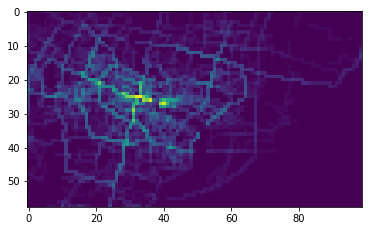

In [30]:
plt.imshow(hist)
plt.show()

In [33]:
X_sub['hour'] = 9

/home/jachinshen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jachinshen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


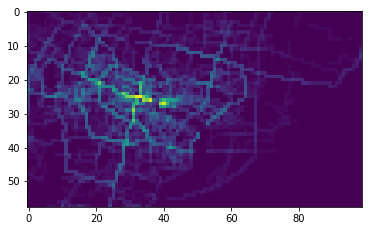

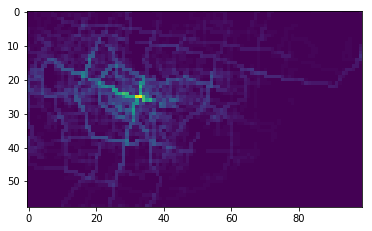

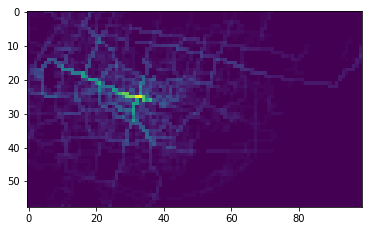

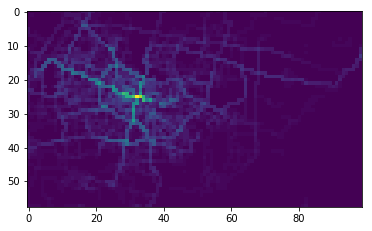

In [43]:
def train_baseline():
    frames = []
    data = get_dataset()
    for hour in range(9, 13):
        hist = get_density_hour(data, datetime(2017, 3, 6, hour),
                               datetime(2017, 3, 6, hour+1))
        plt.imshow(hist)
        plt.show()
        X_sub = get_submission_range()
        X_sub['day'] = "20170313"
        X_sub['hour'] = hour
        X_sub['car_number'] = X_sub.apply(
            lambda row: (get_range_density(hist,
                [row['latitude_range'], row['longitude_range']])), axis=1)
        frames.append(X_sub)
    return pd.concat(frames)
submission = train_baseline()

In [44]:
submission = submission.drop(['latitude_range', 'longitude_range'], axis=1)
print(submission)

    grid_id       day  hour  car_number
0         1  20170313     9           8
1         2  20170313     9           6
2         3  20170313     9           9
3         4  20170313     9           0
4         5  20170313     9           2
5         6  20170313     9          14
6         7  20170313     9          20
7         8  20170313     9           8
8         9  20170313     9           9
9        10  20170313     9           2
10       11  20170313     9          15
11       12  20170313     9           6
12       13  20170313     9          10
13       14  20170313     9          14
14       15  20170313     9           1
15       16  20170313     9          15
16       17  20170313     9           4
17       18  20170313     9           3
18       19  20170313     9           8
19       20  20170313     9          10
20       21  20170313     9           8
21       22  20170313     9           7
22       23  20170313     9          11
23       24  20170313     9           1


In [46]:
submission.columns

Index(['grid_id', 'day', 'hour', 'car_number'], dtype='object')

In [48]:
submission.to_csv("./submission.csv", index=False)